In [18]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image processing
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
class ImageFolderWithPaths(ImageFolder):
    # Override the __getitem__ method. This is the method dataloader calls.
    def __getitem__(self, index):
        # This is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # The image file path
        path = self.imgs[index][0]
        # Make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [19]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the custom dataset class
train_dataset = ImageFolderWithPaths('C:/Users/leoac/Downloads/archive/dataset/train', transform=transform)
validation_dataset = ImageFolderWithPaths('C:/Users/leoac/Downloads/archive/dataset/validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
class SupportClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(SupportClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
model = SupportClassifierCNN(num_classes)

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 2

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/2], Loss: 0.1383


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/2], Loss: 0.1145
Finished Training


In [20]:
model.eval()
correct = 0
total = 0
incorrect_images = []

with torch.no_grad():
    for inputs, labels, paths in tqdm(validation_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Track incorrect predictions
        for i in range(len(labels)):
            if predicted[i] != labels[i]:

                incorrect_images.append((paths[i], inputs[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
incorrect_images_paths = []
for image in incorrect_images:
    incorrect_images_paths.append(image[0])

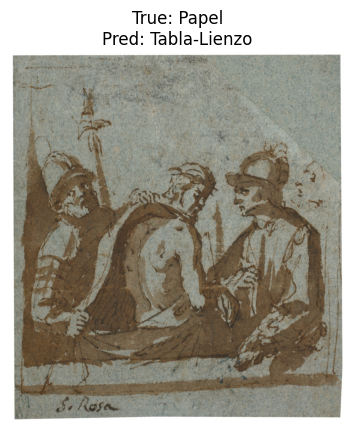

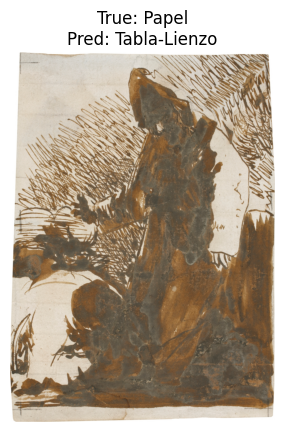

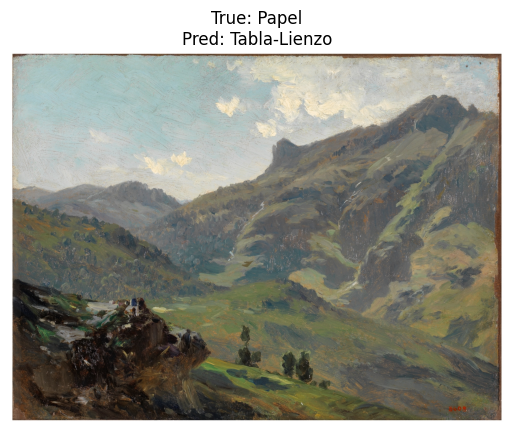

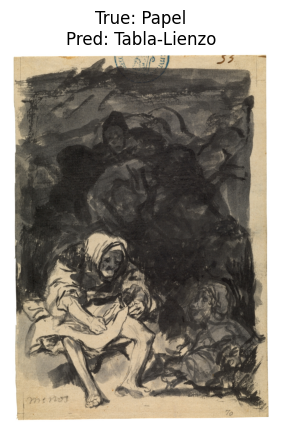

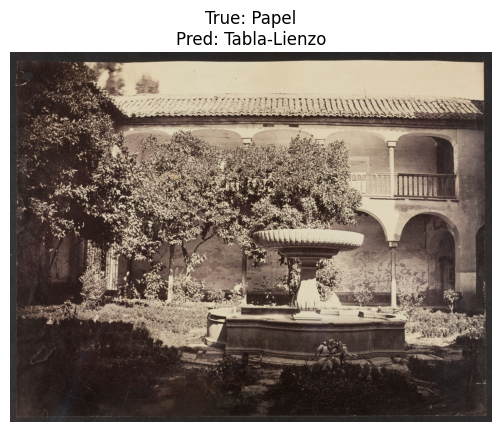

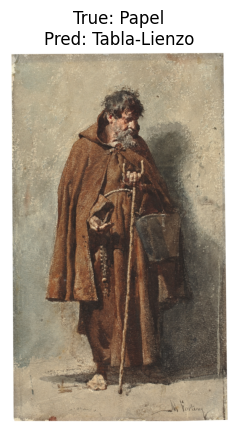

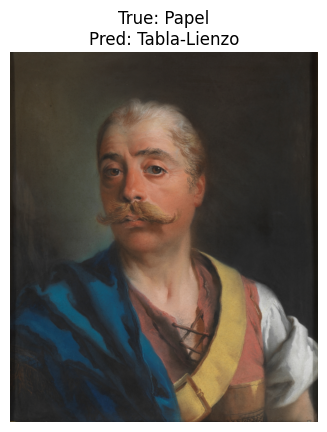

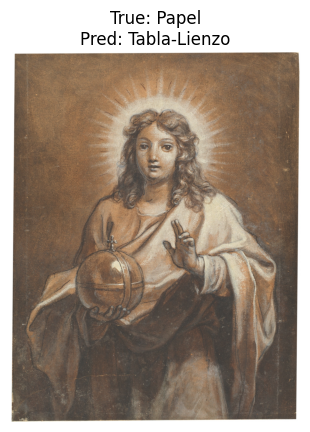

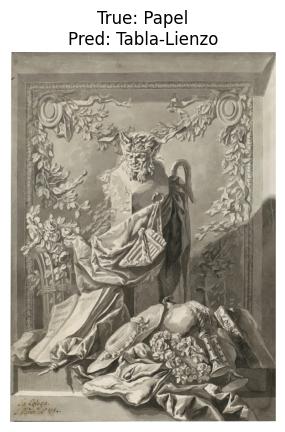

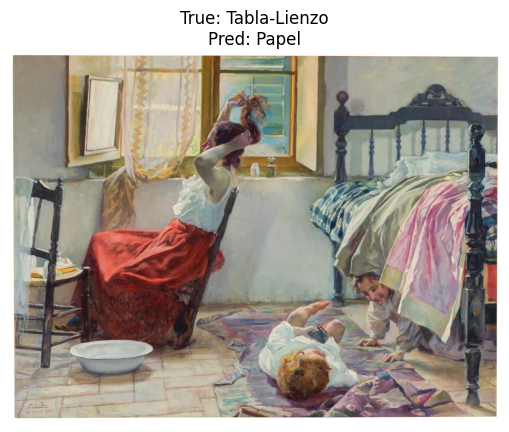

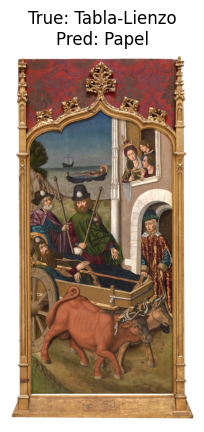

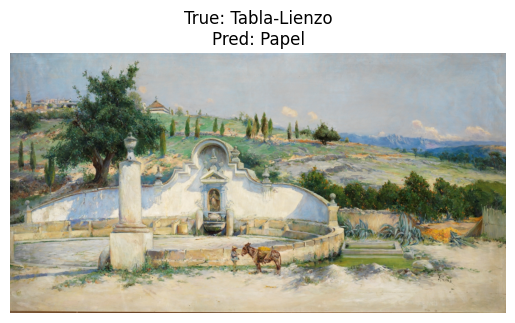

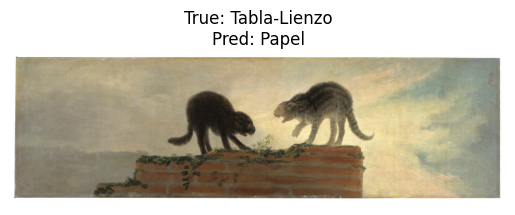

In [28]:
for img_path, img_tensor, true_label, pred_label in incorrect_images:
    # Load the image
    img = Image.open(img_path)
    
    # Plot the image
    plt.imshow(img)
    plt.title(f'True: {train_dataset.classes[true_label]}\nPred: {train_dataset.classes[pred_label]}')
    plt.axis('off')
    plt.show()


In [29]:
torch.save(model.state_dict(), 'prado_artwork_support_classifier.pth')

In [31]:
# Load the model from the file
model.load_state_dict(torch.load('prado_artwork_support_classifier.pth'))

# Define the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

###############
#Mean Values [0.485, 0.456, 0.406]:
# These are the mean values for each of the RGB channels calculated from the ImageNet dataset.
# 0.485 is the mean for the Red channel.
# 0.456 is the mean for the Green channel.
# 0.406 is the mean for the Blue channel.

# Standard Deviation Values [0.229, 0.224, 0.225]:
# These are the standard deviation values for each of the RGB channels calculated from the ImageNet dataset.
# 0.229 is the standard deviation for the Red channel.
# 0.224 is the standard deviation for the Green channel.
# 0.225 is the standard deviation for the Blue channel.
###############

# Function to predict the support type of an unseen image
def predict_image(image_path, model, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

# Path to an unseen image
unseen_image_path = r"C:\Users\leoac\Downloads\archive\images\images\00cdfcee-b12d-4505-b681-a97b2eaa1e34.jpg"

# Predict the support type of the unseen image
predicted_support_index = predict_image(unseen_image_path, model, transform)
predicted_support = train_dataset.classes[predicted_support_index]

print(f'The predicted support type is: {predicted_support}')

The predicted support type is: Papel
